# App example usage

In [14]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import requests
import pandas as pd
import datetime
from datetime import datetime as dt
import holidays

In [16]:
# Load the saved model
with open("../models/best_xgboost.pkl", "rb") as file:
    model = pickle.load(file)


# GET THE WEATHER FORECAST

In [17]:
def map_weather_code(openweather_code):
    """
    Maps OpenWeather weather codes to custom weather codes.

    Parameters:
    - openweather_code (int): Weather code from OpenWeather API.

    Returns:
    - int: Custom weather code for the dataset.
    """
    if openweather_code == 800:
        return 1  # Clear
    elif openweather_code in [801, 802]:  # Few clouds or scattered clouds
        return 2
    elif openweather_code == 803:  # Broken clouds
        return 3
    elif openweather_code == 804:  # Overcast clouds
        return 4
    elif 200 <= openweather_code <= 232:  # Thunderstorm
        return 10
    elif 300 <= openweather_code <= 321 or 500 <= openweather_code <= 531:  # Drizzle or Rain
        return 7
    elif 600 <= openweather_code <= 622:  # Snow
        return 26
    elif openweather_code in [711, 741, 721, 701]:  # Fog/Mist/Haze
        return 94
    else:
        return 0  # Default value for unexpected weather codes


In [18]:
# API Key OpenWeatherMap
api_key = "d925b341419e7674bebad65b41338d8e"

# Miasto i kraj
city = "London"
country = "GB"

# URL API do prognozy godzinowej
url = f"http://api.openweathermap.org/data/2.5/forecast?q={city},{country}&units=metric&appid={api_key}"

# Pobieranie danych
response = requests.get(url)
response

<Response [200]>

In [24]:
if response.status_code == 200:
    forecast = response.json()

    # Ustawienia dla świąt
    uk_holidays = holidays.UnitedKingdom()

    # Przetwarzanie prognozy
    processed_forecast = []
    for item in forecast["list"]:
        # Dane pogodowe
        openweather_code = item["weather"][0]["id"]  # Kod z OpenWeather
        custom_code = map_weather_code(openweather_code)  # Mapowanie na własny kod

        # Dodajemy inne cechy
        date = dt.strptime(item["dt_txt"], "%Y-%m-%d %H:%M:%S")
        temp_C = item["main"]["temp"]
        humidity_percent = item["main"]["humidity"]
        wind_speed_kmh = item["wind"]["speed"] * 3.6  # Konwersja z m/s na km/h
        hour = date.hour
        month = date.month
        weekday = date.weekday()
        is_weekend = 1 if weekday in [5, 6] else 0

        # Obliczenie season
        if month in [3, 4, 5]:
            season = 0  # Spring
        elif month in [6, 7, 8]:
            season = 1  # Summer
        elif month in [9, 10, 11]:
            season = 2  # Fall
        else:
            season = 3  # Winter

        # Sprawdzenie, czy dzień jest świętem
        is_holiday = 1 if date in uk_holidays else 0

        processed_forecast.append({
            "hour": hour,
            "month": month,
            "season": season,
            "is_holiday": is_holiday,
            "is_weekend": is_weekend,
            "temp_C": temp_C,
            "humidity_percent": humidity_percent,
            "wind_speed_kmh": wind_speed_kmh,
            "weather_code": custom_code  # Dodajemy nasz kod
        })

    # Konwersja do DataFrame
    forecast_df = pd.DataFrame(processed_forecast)
    print(forecast_df.head())

else:
    print("Failed to fetch forecast data")


   hour  month  season  is_holiday  is_weekend  temp_C  humidity_percent  \
0     0      1       3           0           0    3.92                82   
1     3      1       3           0           0    3.91                81   
2     6      1       3           0           0    3.91                83   
3     9      1       3           0           0    3.87                85   
4    12      1       3           0           0    6.84                78   

   wind_speed_kmh  weather_code  
0          11.268             4  
1          10.980             4  
2          10.944             4  
3           8.568             3  
4           9.108             3  


In [30]:
# Kopiujemy dane prognozowe
forecast_data_normalized = forecast_df.copy()

# Wybór cech liczbowych do normalizacji
numerical_features = ["temp_C", "humidity_percent", "wind_speed_kmh"]

# Wczytaj scaler i normalizuj tylko cechy numeryczne
scaler_path = "../models/scaler.pkl"
with open(scaler_path, "rb") as file:
    scaler = pickle.load(file)

forecast_data_normalized[numerical_features] = scaler.transform(forecast_df[numerical_features])

# Upewniamy się, że kolumny są w odpowiedniej kolejności
feature_order = ["season", "month", "hour", "is_holiday", "is_weekend",
                 "temp_C", "humidity_percent", "wind_speed_kmh", "weather_code"]

forecast_data_normalized = forecast_data_normalized[feature_order]

# Wykonujemy predykcję
predictions = model.predict(forecast_data_normalized)

# Dodajemy wyniki do oryginalnych danych
forecast_df["predicted_rentals"] = predictions

# Wyświetlenie wyników
print(forecast_df[["hour", "predicted_rentals"]])


    hour  predicted_rentals
0      0         128.510056
1      3          40.339413
2      6         526.799866
3      9        1816.100220
4     12         892.850281
5     15         786.842468
6     18        1706.045044
7     21         467.175720
8      0         127.674339
9      3          39.603291
10     6         532.400391
11     9        1640.674072
12    12         855.992126
13    15         789.312805
14    18        1475.241699
15    21         572.550049
16     0         136.341003
17     3          66.243752
18     6         524.686829
19     9        1783.945190
20    12         899.079590
21    15         991.204407
22    18        2157.125244
23    21         575.483459
24     0         134.901733
25     3          27.644608
26     6         484.826630
27     9        1757.315796
28    12        1037.400635
29    15        1074.846680
30    18        2314.961670
31    21         608.110901
32     0         327.947998
33     3         105.969688
34     6          78

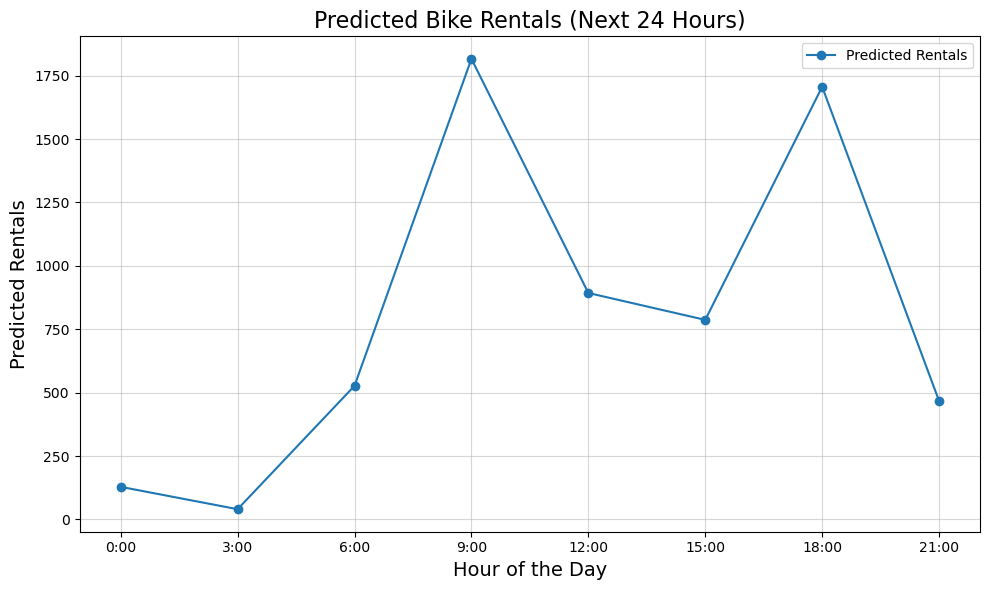

In [31]:
# Filtrujemy tylko pierwsze 8 rekordów
forecast_24h = forecast_df.head(8)

# Sprawdzamy, czy dane są poprawne
if "hour" not in forecast_24h.columns or "predicted_rentals" not in forecast_24h.columns:
    print("Error: Required columns ('hour' or 'predicted_rentals') are missing in forecast_df.")
else:
    # Tworzenie wykresu
    plt.figure(figsize=(10, 6))
    plt.plot(forecast_24h["hour"], forecast_24h["predicted_rentals"], marker="o", label="Predicted Rentals")
    plt.title("Predicted Bike Rentals (Next 24 Hours)", fontsize=16)
    plt.xlabel("Hour of the Day", fontsize=14)
    plt.ylabel("Predicted Rentals", fontsize=14)
    plt.xticks(ticks=forecast_24h["hour"], labels=[f"{hour}:00" for hour in forecast_24h["hour"]])
    plt.grid(alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

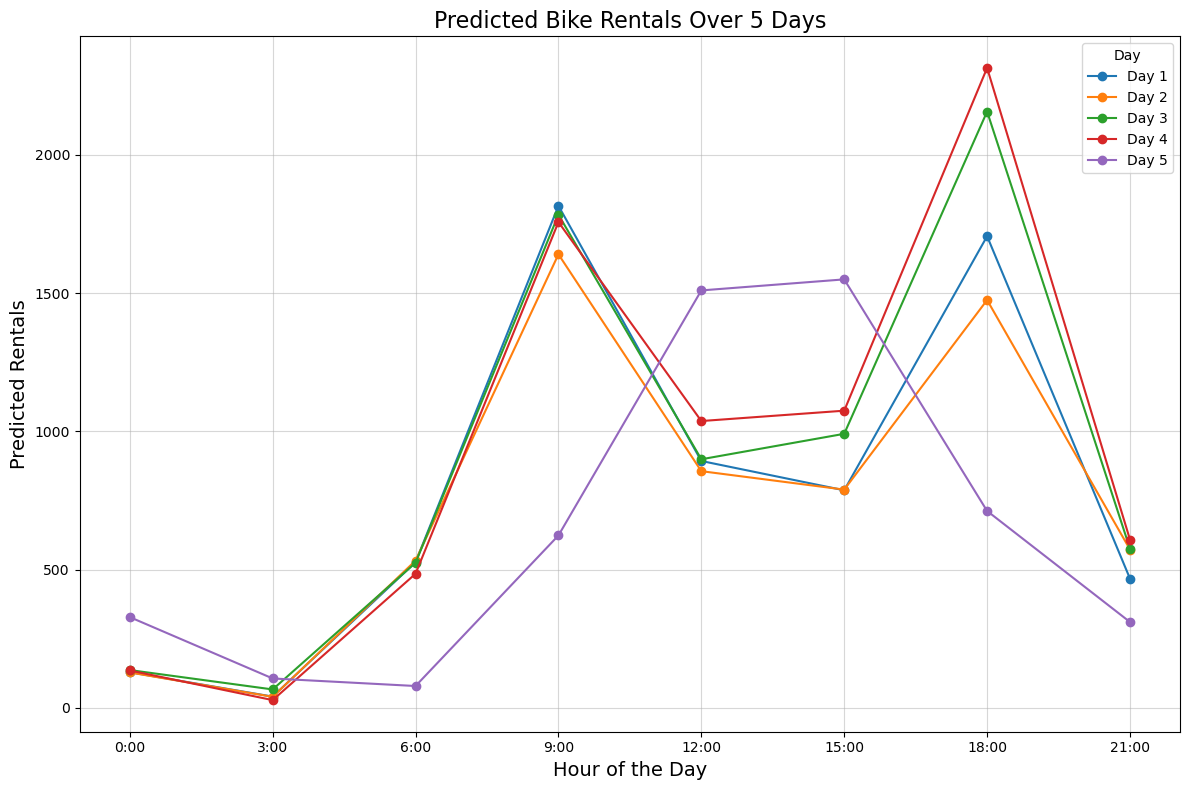

In [32]:
# Dodajemy kolumnę 'day' oznaczającą dni
forecast_df["day"] = (forecast_df.index // 8) + 1

# Tworzenie zbiorczego wykresu dla 5 dni
plt.figure(figsize=(12, 8))
for day in sorted(forecast_df["day"].unique()):
    day_data = forecast_df[forecast_df["day"] == day]
    plt.plot(day_data["hour"], day_data["predicted_rentals"], marker="o", label=f"Day {day}")

# Dostosowanie wyglądu wykresu
plt.title("Predicted Bike Rentals Over 5 Days", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=14)
plt.ylabel("Predicted Rentals", fontsize=14)
plt.xticks(ticks=range(0, 24, 3), labels=[f"{hour}:00" for hour in range(0, 24, 3)])
plt.grid(alpha=0.5)
plt.legend(title="Day")
plt.tight_layout()
plt.show()



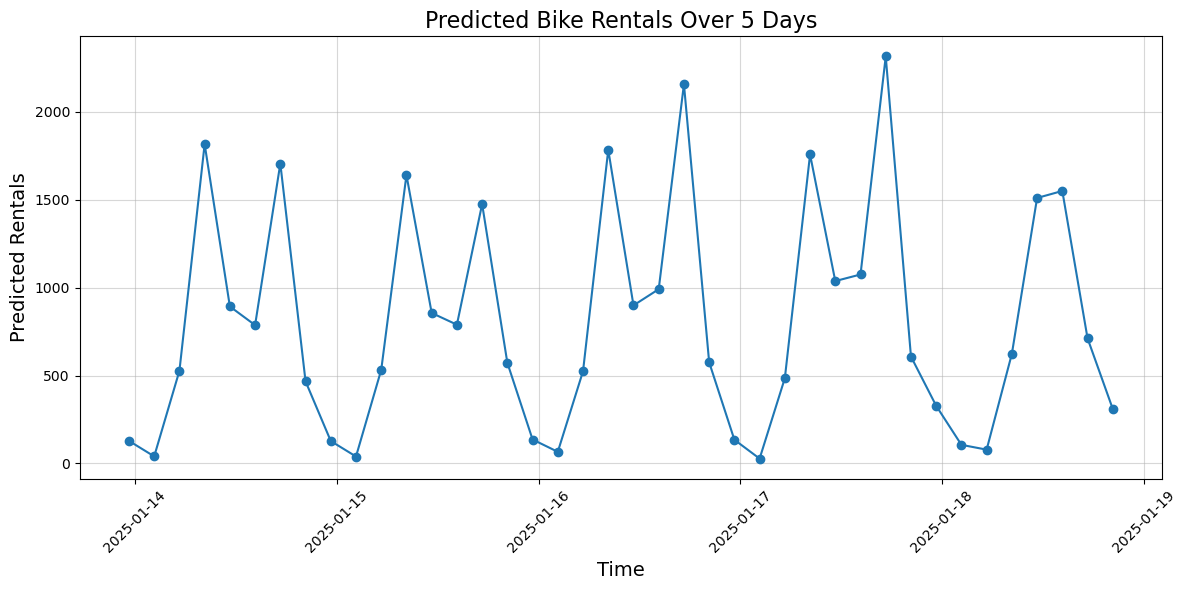

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Dodanie kolumny 'timestamp' na podstawie godzin i dni
start_date = pd.Timestamp.now()  # Zakładamy, że prognoza zaczyna się teraz
forecast_df["timestamp"] = [
    start_date + pd.Timedelta(hours=3 * i) for i in range(len(forecast_df))
]

# Wykres ciągłego czasu
plt.figure(figsize=(12, 6))
plt.plot(forecast_df["timestamp"], forecast_df["predicted_rentals"], marker="o", label="Predicted Rentals")
plt.title("Predicted Bike Rentals Over 5 Days", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Predicted Rentals", fontsize=14)
plt.grid(alpha=0.5)
plt.xticks(rotation=45)  # Obracamy etykiety osi X dla czytelności
plt.tight_layout()
plt.show()
